# Standard RB in Low Data Regime

In [1]:
import warnings
warnings.filterwarnings("ignore") # bad practice, but pystan has a bunch of annoying warnings

%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pystan as ps
import numpy as np
import utils as su
import os
import seaborn as sbn
import time
import dill
import copy

su.overwrite = True

## Data Generation

Load in the simulated survival probabilities from Mathematica's output, and use it to simulate some bernoulli trials.

In [2]:
rbd = su.RBSimData('../data/overrotation_model_survivals.h5')
survivals = rbd.survival_data[:,0,:,0]

mlist = rbd.sequence_lengths
Nm = mlist.shape[0]

def create_data(Nbin=5, Nsamp=3):
    datavals = np.empty((Nm, Nsamp), dtype='int')
    for idx_m, m in enumerate(mlist):

        survival_idxs = np.random.randint(survivals.shape[1], size=Nsamp)
        p = np.clip(survivals[idx_m, survival_idxs],0,1)
        datavals[idx_m,:] = np.random.binomial(Nbin,p)

    data = su.rb_lsf_completion(
        dict(
            Nm=Nm, Nsamp=Nsamp, Nbin=Nbin, Nc=10,
            m=mlist,
            Q=datavals,
            d=2
        ),
       method=su.rb_lsf
    )
    
    return data

Make sure everything is looking okay:

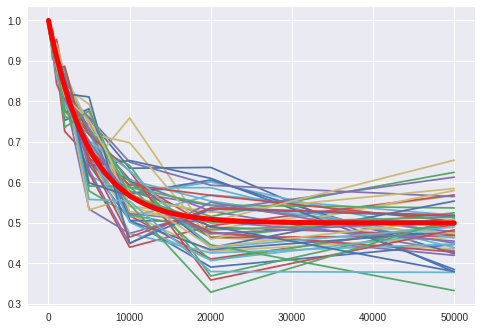

In [3]:
for idx in range(50):
    data = create_data(Nbin=50,Nsamp=20)
    plt.plot(
        data['m'],
        np.mean(data['Q']/float(data['Nbin']),axis=1)
    )
plt.plot(
    np.linspace(1,50000,200),
    0.5*0.9998**np.linspace(1,50000,200) + 0.5,
    zorder=1000,
    lw=5,
    c='r'
)

## Bayesian Fits

Initialize some variables and load in the stan model.

In [4]:
# parameters for the big loop. number of posteriors is the product of these lengths:
n_samps = [1,3,4,5,6,7,8,9,10,15,20,30,50,100]
n_bins = [5]
n_trials = 300

levels = np.arange(0.05,0.95,0.05)
n_levels = len(levels)
max_rhats = np.empty((n_trials, len(n_bins), len(n_samps)))
quantiles = np.empty((n_trials, len(n_bins), len(n_samps), n_levels))
bayes_estimates = np.empty((n_trials, len(n_bins), len(n_samps)))

computed_mask = np.zeros((n_trials, len(n_bins), len(n_samps))).astype(bool)

save_dir = '../data/many_fits/'
# it is important for pickling that every fit have the exact same model instance.
try:
    with open(os.path.join(save_dir, 'model.dill'), 'rb') as f:
        model_beta = dill.load(f)
    print 'Found model and loaded it.'
except:
    model_beta = su.StanModelFactory('./stan/rb-beta-r.stan').model
    with open(os.path.join(save_dir, 'model.dill'), 'wb') as f:
        dill.dump(model_beta, f)

Found model and loaded it.


The following loop does all of the Bayesian fitting, storing some results to disk. It will probably take overnight.

In [5]:
def subdata(data, Nsamp):
    # reduces the amount of data to Nsamp, keeping values the same
    d = data.copy()
    d['Nsamp'] = Nsamp
    d['Q'] = d['Q'][:,:Nsamp]
    return d

def max_rhat(fit):
    rhats = fit.summary()['summary'][:-1,-1]
    return np.max(rhats[np.logical_not(np.isnan(rhats))])

def compute_quantiles(fit, levels=[0.05,0.5], param='p'):
    vals = fit.extract()[param]
    return np.percentile(vals, 100*np.array(levels))

def bayes_estimate(fit, param='p'):
    vals = fit.extract()[param]
    return np.mean(vals)

def save_fit_results(filename, fit):
    fit_results = dict(copy.deepcopy(fit.extract()))
    fit_results['max_rhat'] = np.array(np.nanmax(fit.summary()['summary'][:-1,-1]))
    for x in ['a', 'b', 'p_err', 'mu', 'lp__', 'r', 'A_err', 'B_err', 'log_lik']:
        fit_results.pop(x)
    np.savez(filename, **fit_results)
    return fit_results

if False:
    for idx_trial in range(200,n_trials):
        print 'Starting trial {} at {}...'.format(idx_trial, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        for idx_n_bin, n_bin in enumerate(n_bins):
            try:
                with open(os.path.join(save_dir, 'data_{}_{}.dill'.format(idx_trial, n_bin)), 'rb') as f:
                    data = dill.load(f)
            except:
                data = create_data(Nsamp=np.max(n_samps), Nbin=n_bin)
                with open(os.path.join(save_dir, 'data_{}_{}.dill'.format(idx_trial, n_bin)), 'wb') as f:
                    dill.dump(data, f)

            for idx_n_samp, n_samp in enumerate(n_samps):
                file_name = os.path.join(save_dir, 'fit_{}_{}_{}.npz'.format(idx_trial, n_bin, n_samp))
                if not os.path.isfile(file_name):
                    fit = model_beta.sampling(
                        data=subdata(data, n_samp), 
                        iter=2000, 
                        chains=3, 
                        warmup=1000, 
                        control=dict(adapt_delta=0.98)
                    )
                    save_fit_results(file_name, fit)
                    print 'Computed and saved I={}.'.format(n_samp)
                    max_rhats[idx_trial, idx_n_bin, idx_n_samp] = max_rhat(fit)
                    bayes_estimates[idx_trial, idx_n_bin, idx_n_samp] = bayes_estimate(fit)
                    quantiles[idx_trial, idx_n_bin, idx_n_samp,:] = compute_quantiles(fit, levels = levels)
                    computed_mask[idx_trial,idx_n_bin,idx_n_samp] = True

                    del fit

So that we don't have to run the above code every time, we can also load our previous results from disk and recalculate the quantiles, etc.

In [6]:
def max_rhat(fit):
    rhats = fit.summary()['summary'][:-1,-1]
    return np.max(rhats[np.logical_not(np.isnan(rhats))])

def compute_quantiles(fit, levels=[0.05,0.5], param='p'):
    vals = fit[param]
    return np.percentile(vals, 100*np.array(levels))

def bayes_estimate(fit, param='p'):
    vals = fit[param]
    return np.mean(vals)

try:
    for idx_trial in range(n_trials):
        for idx_n_bin, n_bin in enumerate(n_bins):
            for idx_n_samp, n_samp in enumerate(n_samps):
                if not computed_mask[idx_trial, idx_n_bin, idx_n_samp]:
                    file_name = os.path.join(save_dir, 'fit_{}_{}_{}.npz'.format(idx_trial, n_bin, n_samp))
                    try:
                        fit_results = np.load(file_name)
                        max_rhats[idx_trial, idx_n_bin, idx_n_samp] = fit_results['max_rhat']
                        bayes_estimates[idx_trial, idx_n_bin, idx_n_samp] = bayes_estimate(fit_results)
                        quantiles[idx_trial, idx_n_bin, idx_n_samp,:] = compute_quantiles(fit_results, levels = levels)

                    except:
                        print 'Something went wrong with {}'.format(file_name)
        if np.mod(idx_trial, 10) == 0:
            print 'Completed Trial {}.'.format(idx_trial)
except IOError:
    print "All results have not been saved to disk yet. Run the previous cell with a True if statement."
    raise

Completed Trial 0.
Completed Trial 10.
Completed Trial 20.
Completed Trial 30.
Completed Trial 40.
Completed Trial 50.
Completed Trial 60.
Completed Trial 70.
Completed Trial 80.
Completed Trial 90.
Completed Trial 100.
Completed Trial 110.
Completed Trial 120.
Completed Trial 130.
Completed Trial 140.
Completed Trial 150.
Completed Trial 160.
Completed Trial 170.
Completed Trial 180.
Completed Trial 190.
Completed Trial 200.
Completed Trial 210.
Completed Trial 220.
Completed Trial 230.
Completed Trial 240.
Completed Trial 250.
Completed Trial 260.
Completed Trial 270.
Completed Trial 280.
Completed Trial 290.


## Bootstrap Fits

Now we move on to the bootstrap fits. Try to load them from disk, and if they don't exist, compute them and save to disk.

In [7]:
try:
    bootstrap_distros_nonparam = np.load('../data/bootstrap_distros_nonparam.npy')
    bootstrap_distros_param = np.load('../data/bootstrap_distros_param.npy')
    quantiles_bootstrap_nonparam = np.load('../data/quantiles_bootstrap_nonparam.npy')
    quantiles_bootstrap_param = np.load('../data/quantiles_bootstrap_param.npy')
    mles = np.load('../data/mles.npy')
except IOError:
    
    bootstrap_distros_nonparam = np.empty((n_trials,len(n_bins),len(n_samps),600))
    bootstrap_distros_param = np.empty((n_trials,len(n_bins),len(n_samps),600))
    quantiles_bootstrap_nonparam = np.empty((n_trials, len(n_bins), len(n_samps), n_levels))
    quantiles_bootstrap_param = np.empty((n_trials, len(n_bins), len(n_samps), n_levels))
    mles = np.empty((n_trials, len(n_bins), len(n_samps)))

    from multiprocessing import Pool

    def compute_mle_p(data):
        # note we are only using the fit for its data
        return su.mle(data)[2]

    def load_data(file_name, n_samp):
        with open(file_name, 'rb') as f:
            data = dill.load(f)
        return subdata(data, n_samp)

    def bootstrap_dist_worker(args):
        n, nonparam = args
        if nonparam:
            return su.bootstrap_ABp_mle(data, n, sampler=su.bootstrap_nonparam_sample)[:,2]
        else:
            return su.bootstrap_ABp_mle(data, n, sampler=su.bootstrap_param_sample)[:,2]

    def compute_bootstrap(nonparam=True):
        # note we are only using the fit for its data
        pool = Pool(processes=4)
        dist = np.concatenate(
            pool.map(bootstrap_dist_worker, [(150,nonparam)] * 4)
        )
        pool.close()
        return dist

    for idx_trial in range(263,n_trials):
        for idx_n_bin, n_bin in enumerate(n_bins):
            for idx_n_samp, n_samp in enumerate(n_samps):
                file_name = os.path.join(save_dir, 'data_{}_{}.dill'.format(idx_trial, n_bin, n_samp))
                try:
                    data = load_data(file_name, n_samp)

                    dist = compute_bootstrap(nonparam=True)
                    bootstrap_distros_nonparam[idx_trial, idx_n_bin, idx_n_samp, :] = dist
                    quantiles_bootstrap_nonparam[idx_trial, idx_n_bin, idx_n_samp,:] = np.percentile(dist, 100*np.array(levels))

                    dist = compute_bootstrap(nonparam=False)
                    bootstrap_distros_param[idx_trial, idx_n_bin, idx_n_samp, :] = dist
                    quantiles_bootstrap_param[idx_trial, idx_n_bin, idx_n_samp,:] = np.percentile(dist, 100*np.array(levels))

                    mles[idx_trial, idx_n_bin, idx_n_samp] = compute_mle_p(data)

                    print 'Completed {} at {}...'.format(file_name, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
                except:
                    raise
                    print 'Something went wrong with {}'.format(file_name)
        print '>>>>>>> Completed Trial {}.'.format(idx_trial)
        
    np.save('../data/bootstrap_distros_nonparam.npy', bootstrap_distros_nonparam)
    np.save('../data/bootstrap_distros_param.npy', bootstrap_distros_param)
    np.save('../data/quantiles_bootstrap_nonparam.npy', quantiles_bootstrap_nonparam)
    np.save('../data/quantiles_bootstrap_param.npy', quantiles_bootstrap_param)
    np.save('../data/mles.npy', mles)

## Plots

In [8]:
def load_fit(idx_trial, n_bin, n_samp):
    file_name = os.path.join(save_dir, 'fit_{}_{}_{}.npz'.format(idx_trial, n_bin, n_samp))
    d = np.load(file_name)
    return d['p']

Quick test plots of the bootstap distro vs the posterior for some trial.

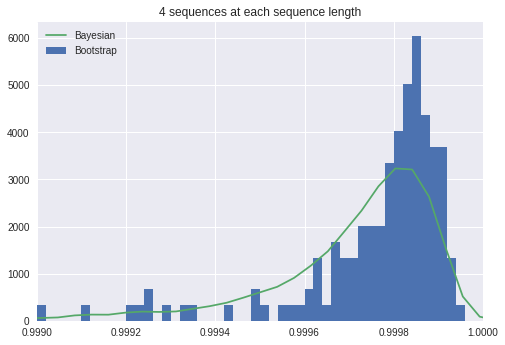

In [9]:
idx_trial=50
idx=2

fit = load_fit(idx_trial, 5, n_samps[idx])

plt.figure()
plt.hist(bootstrap_distros_nonparam[idx_trial,0,idx,:], bins=50, range=(0.999,1), normed=True, label='Bootstrap')
sbn.kdeplot(fit, label='Bayesian')
plt.xlim([0.999,1])
plt.title('{} sequences at each sequence length'.format(n_samps[idx]))

In [11]:
quantiles_bootstrap_nonparam = np.empty((n_trials, len(n_bins), len(n_samps), n_levels))
quantiles_bootstrap_param = np.empty((n_trials, len(n_bins), len(n_samps), n_levels))
mles = np.empty((n_trials, len(n_bins), len(n_samps)))
for idx_trial in range(n_trials):
    for idx_n_bin, n_bin in enumerate(n_bins):
        for idx_n_samp, n_samp in enumerate(n_samps):
            dist = bootstrap_distros_nonparam[idx_trial,idx_n_bin,idx_n_samp,:]
            mask = dist > 0.5
            if np.sum(mask) > 0:
                quantiles_bootstrap_nonparam[idx_trial,idx_n_bin,idx_n_samp,:] = np.percentile(
                    dist[mask], 
                    100*np.array(levels)
                )
            else:
                quantiles_bootstrap_nonparam[idx_trial,idx_n_bin,idx_n_samp,:] = 0
                
            dist = bootstrap_distros_param[idx_trial,idx_n_bin,idx_n_samp,:]
            mask = dist > 0.5
            if np.sum(mask) > 0:
                quantiles_bootstrap_param[idx_trial,idx_n_bin,idx_n_samp,:] = np.percentile(
                    dist[mask], 
                    100*np.array(levels)
                )
            else:
                quantiles_bootstrap_param[idx_trial,idx_n_bin,idx_n_samp,:] = 0
                
                
            
            file_name = os.path.join(save_dir, 'fit_{}_{}_{}.dill'.format(idx_trial, 5, n_samps[idx_n_samp]))
            #with open(file_name, 'rb') as f:
            #    fit = dill.load(f)
            #mles[idx_trial, idx_n_bin, idx_n_samp] = compute_mle_p(fit)

Overwriting ../fig/low-data.png
Overwriting ../fig/low-data.pdf


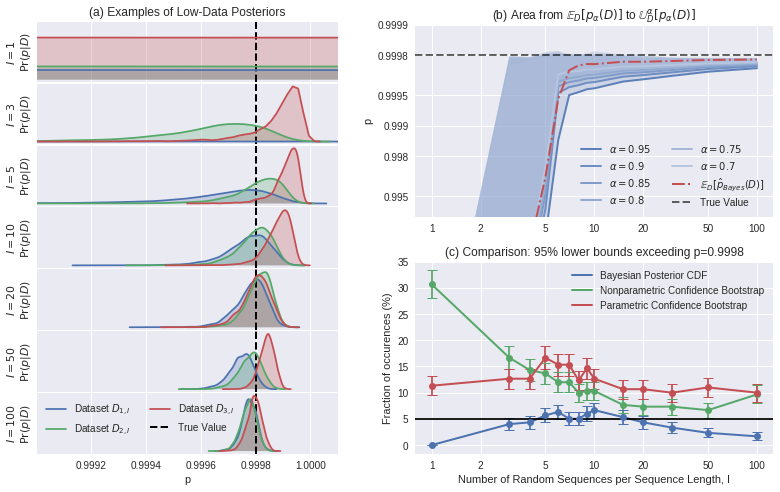

In [12]:
fig = plt.figure(figsize=(11,7))
marginals_to_plot = np.array(n_samps)[[0,1,3,8,10,12,-1]]
gs1 = gridspec.GridSpec(len(marginals_to_plot),1, left=0, bottom=0, right=0.45, top=1)
gs2 = gridspec.GridSpec(2,1, left=0.55, bottom=0, right=1, top=1)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#----------------------------------------
# Marginal KDEs
#----------------------------------------

for idx_n_samp, n_samp in enumerate(marginals_to_plot):
    plt.sca(plt.subplot(gs1[idx_n_samp]))
    sbn.kdeplot(load_fit(17,5,n_samp), label='Dataset $D_{1,I}$', shade=True, zorder=1000-idx_n_samp)
    sbn.kdeplot(load_fit(10,5,n_samp), label='Dataset $D_{2,I}$', shade=True, zorder=1000-idx_n_samp)
    sbn.kdeplot(load_fit(5,5,n_samp), label='Dataset $D_{3,I}$', shade=True, zorder=1000-idx_n_samp)
    plt.axvline(0.9998, lw=2, linestyle='--',c='k', label='True Value')
    plt.xticks([0.9992,0.9994,0.9996,0.9998,1])
    plt.xlim([0.999,1.0001])
    plt.yticks([])
    plt.ylabel('$I={{{}}}$\n$\operatorname{{Pr}}(p|D)$'.format(n_samp))
    if idx_n_samp < len(marginals_to_plot)-1:
        plt.gca().set_xticklabels([])
        plt.legend([])
    else:
        plt.legend(ncol=2)
        plt.xlabel('p')
    if idx_n_samp == 0:
        plt.title('(a) Examples of Low-Data Posteriors')
    
#----------------------------------------
# Area Plot
#----------------------------------------

plt.sca(plt.subplot(gs2[0]))
for idx in [0,1,2,3,4,5]:
    level = levels[idx]
    color = su.lighten_color(colors[0], 1-2*level)
    plt.plot(n_samps, 1-mean_quantiles[:,idx], label=r'$\alpha={}$'.format(1-level), zorder=101,lw=2, c=color)
    plt.fill_between(n_samps, 1-mean_quantiles[:,idx], 1-upper_quantiles[:,idx], zorder=95, alpha=0.2, facecolor=color)

plt.plot(n_samps, 1-expected_bayes, label=r'$\mathbb{E}_D[\hat{p}_{Bayes}(D)]$', zorder=110,ls='-.', lw=2, c=colors[2])
    
plt.axhline(1-0.9998, c='k', linestyle='--', linewidth=2, label='True Value', zorder=150, alpha=0.6)

# the following axis craziness is to make clear the action at the turning point of the curves
# we put a standard log scale on the x-axis
# for the y axis, we put a log scale on (1-yvalue) and then flip it upside down, and relabel the ticks 
# so that no one knows we did this and flipped it upside down.
plt.xscale('log', base=10)
plt.yscale('log')
plt.xticks([1,2,5,10,20,50,100])
plt.yticks(1-np.array([0.98,0.99,0.995,0.998,0.999,0.9995,0.9998,0.9999]))
plt.gca().get_xaxis().set_major_formatter(ticker.ScalarFormatter())
def invticks(y, pos):
    return '{}'.format(1-y)
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(invticks))
#plt.xlim([2,105])
plt.ylim([0.0001,0.008])
plt.gca().invert_yaxis()
plt.legend(loc=4, ncol=2)
plt.ylabel('p')
plt.title(r'(b) Area from $\mathbb{E}_D[p_{\alpha}(D)]$ to $\mathbb{U}^{\alpha}_D[p_{\alpha}(D)]$')
                        
#----------------------------------------
# Bootstrap Comparison
#----------------------------------------

plt.sca(plt.subplot(gs2[1]))
bad_fraction_nonparam = np.empty((len(n_samps),n_levels))
bad_fraction_param = np.empty((len(n_samps),n_levels))
bad_fraction_bayes = np.empty((len(n_samps),n_levels))
for idx_n_samp, n_samp in enumerate(n_samps):
    # we postselect on those bootstrap distros that report p>0.2, attributing
    # those which are lower to bad gradient ascents.
    mask = np.mean(bootstrap_distros_nonparam[:,idx_n_bin,idx_n_samp,:], axis=-1) > 0.2
    q = quantiles_bootstrap_nonparam[mask, idx_n_bin, idx_n_samp, :]
    bad_fraction_nonparam[idx_n_samp,:] = np.sum(q > 0.9998, axis=0) / float(n_trials)
    
    mask = np.mean(bootstrap_distros_param[:,idx_n_bin,idx_n_samp,:], axis=-1) > 0.2
    q = quantiles_bootstrap_param[mask, idx_n_bin, idx_n_samp, :]
    bad_fraction_param[idx_n_samp,:] = np.sum(q > 0.9998, axis=0) / float(n_trials)
    
    mask = max_rhats[:,idx_n_bin,idx_n_samp] < 1.1
    q = quantiles[mask, idx_n_bin, idx_n_samp, :]
    bad_fraction_bayes[idx_n_samp,:] = np.sum(q > 0.9998, axis=0) / float(n_trials)
    
idx_level = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels = [
    'Bayesian Posterior CDF',
    'Nonparametric Confidence Bootstrap',
    'Parametric Confidence Bootstrap'
]
ys = [
    bad_fraction_bayes[:,idx_level],
    bad_fraction_nonparam[:,idx_level],
    bad_fraction_param[:,idx_level]
]
for color, label, y in zip(colors, labels, ys):
    y_err = np.sqrt(y * (1 - y) / n_trials)
    plt.plot(n_samps, 100* y, lw=2, label=label, color=color)
    _, caps, _  = plt.errorbar(n_samps, 100* y, yerr=100* y_err, fmt='o', color=color, capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)
    
plt.axhline(100* levels[idx_level] , color='k')

plt.legend()
plt.xscale('log')
plt.xticks([1,2,5,10,20,50,100])
plt.gca().get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.xlabel('Number of Random Sequences per Sequence Length, I')
plt.ylabel('Fraction of occurences (%)')
plt.title('(c) Comparison: {}% lower bounds exceeding p=0.9998'.format(
    int(np.round(100*(1-levels[idx_level])))))
        
gs1.tight_layout(fig, h_pad=0.1, rect=(0,0,0.45,1))
gs2.tight_layout(fig, rect=(0.45,0,1,1))

su.export_figure(fig, 'low-data')